あるストリーミングサービスの解約率を調べるという状況を想定する  
まずはデータ生成を行う  

ここで解約率を推定するために利用できるデータは以下のものとする。

| 項目 | 説明 | 分布 | コメント |
| --- | --- | --- | --- |
| DaysSinceLastActivity | 最終ログインからの日数 | 指数分布: 平均10日 | 幽霊アカウントを含めたらこんな感じか？
| HasActivePromotionalOffer | 復帰を促したか | 二項分布: 0 or 1 | -- |
| AverageSessionDuration | 平均セッション時間 | ガンマ分布: (2,15) 平均30分 | 大体の通学時間を想定

In [91]:
using Random

Random.seed!(1234)
n_samples = 1000

1000

10-element Vector{Float64}:
  3.989805872320786
 10.97157487488112
 11.528800883195558
  0.32182180836827007
  9.852672831588938
 14.861479297186445
 44.69383545607664
  3.138659888253987
 10.057130392898497
 16.665226566676623

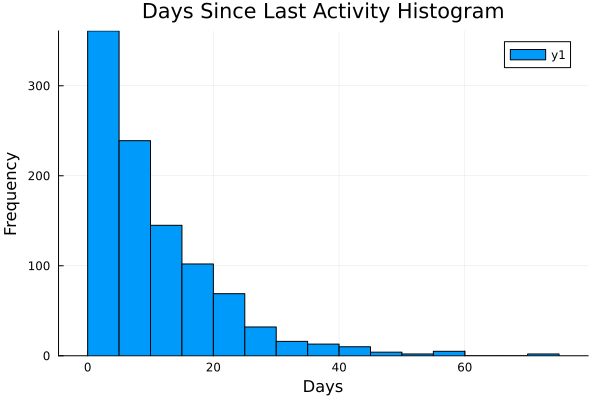

In [92]:
using Distributions
using StatsPlots

DaysSinceLastActivity = rand(Exponential(10), n_samples)
display(first(DaysSinceLastActivity, 10))

histogram(
    DaysSinceLastActivity,
    bins=30,
    title="Days Since Last Activity Histogram",
    xlabel="Days",
    ylabel="Frequency"
)

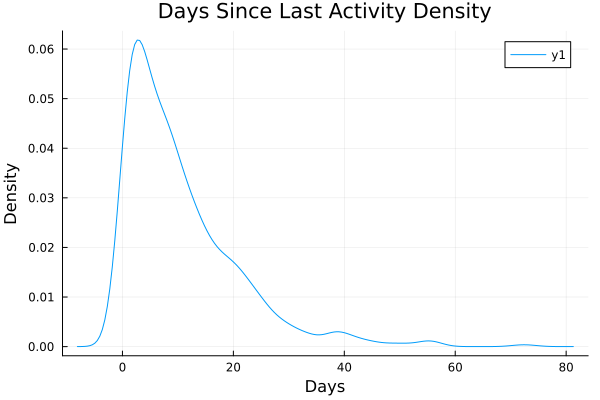

In [93]:
# density plot
density(
    DaysSinceLastActivity,
    title="Days Since Last Activity Density",
    xlabel="Days",
    ylabel="Density",
)

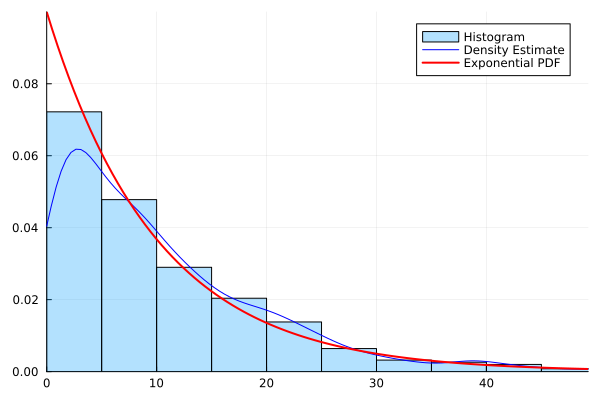

In [94]:
# Combined Histogram and Density plot on the same plot
plots_DaysSinceLastActivity = histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
density!(
    DaysSinceLastActivity,
    fillalpha = 0.6,
    linecolor = :blue,
    label = "Density Estimate",
)
# 指数関数の確率密度関数
x = range(0, quantile(DaysSinceLastActivity, 0.99), length=100)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
display(plots_DaysSinceLastActivity)


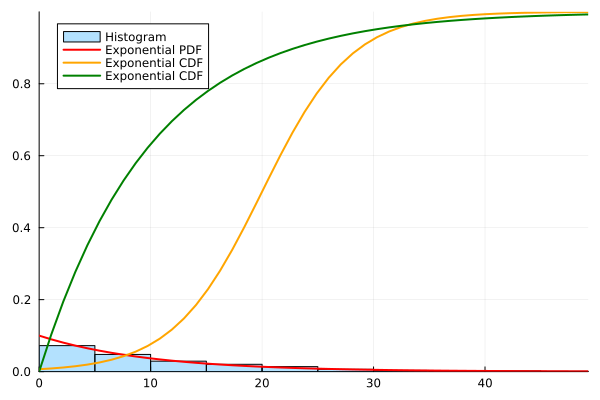

In [121]:
histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
sigmoid(x, m, s) = 1 ./ (1 .+ exp.(-(x .- m) ./ s))
plot!(
    x,
    sigmoid(x, 20, 4),
    linewidth=2,
    color=:orange,
    label="Exponential CDF"
)
plot!(
    x,
    cdf(Exponential(10), x),
    linewidth=2,
    color=:green,
    label="Exponential CDF"
)

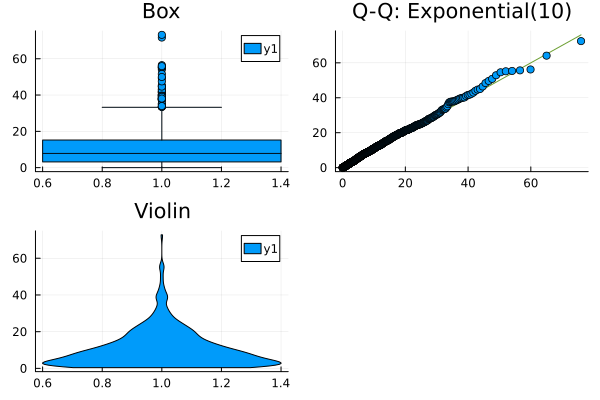

In [96]:
# その他のプロットたち
plot(
    boxplot(
        DaysSinceLastActivity,
        title="Box"
    ),
    qqplot(
        Exponential(10),
        DaysSinceLastActivity,
        title="Q-Q: Exponential(10)",
    ),
    violin(
        DaysSinceLastActivity,
        title="Violin"
    )
)

5-element Vector{Int64}:
 0
 1
 1
 0
 0

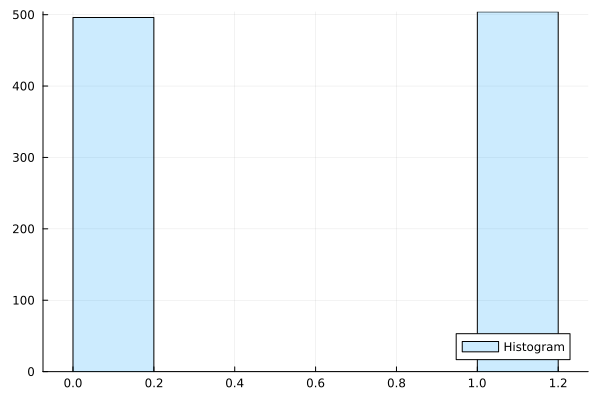

In [97]:
# 次はHasActivePromotionalOffer
HasActivePromotionalOffer = rand([0,1], n_samples)
display(first(HasActivePromotionalOffer, 5))
plots_HasActivePromotionalOffer = histogram(
    HasActivePromotionalOffer,
    fillalpha=0.2,
    label="Histogram"
)
display(plots_HasActivePromotionalOffer)

In [98]:
# AverageSessionDuration
# これはガンマ分布(2,15)
AverageSessionDuration = rand(Gamma(2,15), n_samples)
display(first(AverageSessionDuration, 5))

5-element Vector{Float64}:
 39.26013305811533
 63.38556973255818
 29.298779615357244
 37.88617281099633
 59.433326040070746

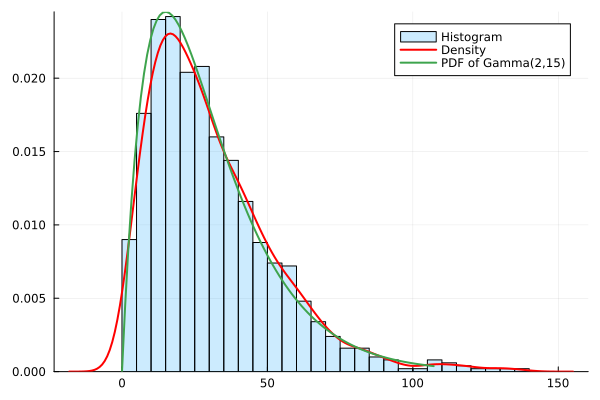

In [99]:
# density & ガンマ分布のpdfも併記
plots_AverageSessionDuration = histogram(
    AverageSessionDuration,
    normalize=true,
    fillalpha=0.2,
    label="Histogram",
)
density!(
    AverageSessionDuration,
    label="Density",
    color="red",
    linewidth=2
)
x = range(0, quantile(AverageSessionDuration, 0.99), length=100)
plot!(
    x,
    pdf(Gamma(2,15), x),
    label="PDF of Gamma(2,15)",
    linewidth=2
)
display(plots_AverageSessionDuration)

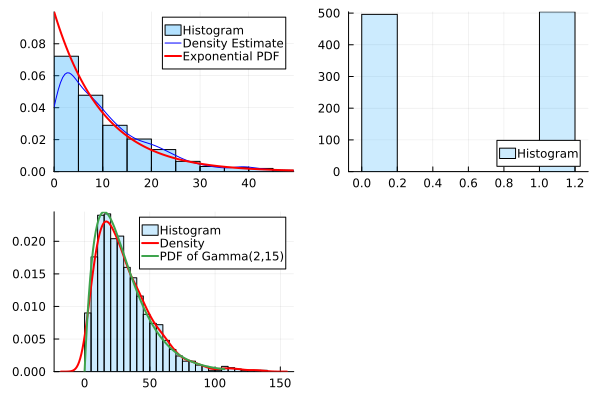

In [100]:
# 3つを並べて表示
plot(
    plots_DaysSinceLastActivity,
    plots_HasActivePromotionalOffer,
    plots_AverageSessionDuration,
    # layout=(3,1)
)


# 解約についてのユーザー設定
解約グループと、そうではない通常グループについての設定（振る舞い）を定義する。

# 最終ログインからの時間 (DaysSinceLastActivity)
- DaysSinceLastActivityは指数分布に従うデータ
- 最終ログインからの時間が長いほど解約率が上がる
- 解約率はシグモイド間数でモデル化
  - 変動させるのは中間パラメータmのみ
  - スケールパラメータmの変更は行わない
## 解約グループ
- 解約グループは解約までの判断が早いと想定
- このユーザは見切りが早く、あっさりと他のサービスに乗り換えてしまう
- 通常m=20のところ、このグループの閾値はm=10とする

# プロモーション (HasActivePromotionalOffer)
- HasActivePromotionalOfferは、行うか行わないかのベルヌーイ分布(0.5)
- プロモーション実施はコストの問題のため全員に行うことはできず、実施確率は５０％となっている
## 解約グループ
- このグループはプロモーションの効きが悪い
- 通常グループではプロモーションに対し５０％の確率で効果あり
- しかし解約グループにはたったの２０％しか効かない

# セッション時間 (AverageSessionDuration)
- AverageSessionDurationgはガンマ分布に従うデータ
- おおよそこのサービスは平均的に３０分再生されている
- そして解約率は平均再生時間に比例して下がる
  - つまり解約率は平均再生時間の指数分布とモデル化できる
  - 指数関数のlambdaを変更することで解約の度合いを変えられる
## 解約グループ
- 解約グループは平均再生時間が仮に長かったとしても、あっさりと解約を行なってしまう

In [101]:
# データの作成は完了
# 次は解約率の設定とそのラベルの作成

labels = zeros(Int, n_samples)

# 解約をシミュレーションしてラベル作成
for i=1:n_samples
    # 最終活動から間が開くほど解約率上昇
    churn_risk_activity = DaysSinceLastActivity[i]
    churn_risk_promotion = HasActivePromotionalOffer[i]
end